# Paddlepaddle实现逻辑回归 - 识别猫

在该实验中，我们将使用PaddlePaddle实现Logistic回归模型来解决识别猫的问题，读者可以一步步跟随内容完成训练，加深对逻辑回归理论内容的理解并串联各个知识点，收获对神经网络和深度学习概念的整体把握。 


** 图片处理 **

由于识别猫问题涉及到图片处理指示，这里对计算机如何保存图片做一个简单的介绍。在计算机中，图片被存储为三个独立的矩阵，分别对应图3-6中的红、绿、蓝三个颜色通道，如果图片是64*64像素的，就会有三个64*64大小的矩阵，要把这些像素值放进一个特征向量中，需要定义一个特征向量X，将三个颜色通道中的所有像素值都列出来。如果图片是64*64大小的，那么特征向量X的总纬度就是64*64*3，也就是12288维。这样一个12288维矩阵就是Logistic回归模型的一个训练数据。

<img src="images/image_to_vector.png" style="width:550px;height:300px;">

## 1 - 引用库

首先，载入几个需要用到的库，它们分别是：
- numpy：一个python的基本库，用于科学计算
- matplotlib.pyplot：用于生成图，在验证模型准确率和展示成本变化趋势时会使用到
- h5py：用于处理hdf5文件数据
- PIL和scipy：用于最后使用自己的图片验证训练模型
- lr_utils：定义了load_datase()方法用于载入数据
- paddle.v2：paddle深度学习平台

In [1]:
import sys
import numpy as np

import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import matplotlib.pyplot as plt

import paddle.v2 as paddle

%matplotlib inline

## 2 - 数据预处理

这里简单介绍数据集及其结构。数据集以hdf5文件的形式存储，包含了如下内容：

- 训练数据集：包含了m_train个图片的数据集，数据的标签（Label）分为cat（y=1）和non-cat（y=0）两类。
- 测试数据集：包含了m_test个图片的数据集，数据的标签（Label）同上。

单个图片数据的存储形式为（num_x, num_x, 3），其中num_x表示图片的长或宽（数据集图片的长和宽相同），数字3表示图片的三通道（RGB）。
在代码中使用一行代码来读取数据，读者暂不需要了解数据的读取过程，只需调用load_dataset()方法，并存储五个返回值，以便后续的使用。
    
需要注意的是，添加“_orig”后缀表示该数据为原始数据，因为之后还需要对数据进行进一步处理。未添加“_orig”的数据则表示之后不对该数据作进一步处理。
在这里需要定义全局变量TRAINING_SET、TEST_SET、DATADIM分别表示最终的训练数据集、测试数据集和数据特征数，便于后续使用，实现函数load_data()，注意，此处为了方便后续的测试工作，添加了合并数据集和标签集的操作，使用numpy.hstack实现numpy数组的横向合并。

In [2]:
# 载入数据(cat/non-cat)
def load_data():
    """
    载入数据，数据项包括：
        train_set_x_orig：原始训练数据集
        train_set_y：原始训练数据标签
        test_set_x_orig：原始测试数据集
        test_set_y：原始测试数据标签
        classes(cat/non-cat)：分类list

    Args:
    Return:
    """
    global TRAINING_SET, TEST_SET, DATADIM, classes

    train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
    m_train = train_set_x_orig.shape[0]
    m_test = test_set_x_orig.shape[0]
    num_px = train_set_x_orig.shape[1]

    # 定义纬度
    DATADIM = num_px * num_px * 3

    # 数据展开,注意此处为了方便处理，没有加上.T的转置操作
    train_set_x_flatten = train_set_x_orig.reshape(m_train, -1)
    test_set_x_flatten = test_set_x_orig.reshape(m_test, -1)

    # 归一化
    train_set_x = train_set_x_flatten / 255.
    test_set_x = test_set_x_flatten / 255.

    TRAINING_SET = np.hstack((train_set_x, train_set_y.T))
    TEST_SET = np.hstack((test_set_x, test_set_y.T))

## 3 - 构造reader

构造两个reader()函数来分别读取训练数据集TRAINING_SET和测试数据集TEST_SET，需要注意的是，yield关键字的作用类似return关键字，但不同指出在于yield关键字让reader()变成一个生成器（Generator），生成器不会创建完整的数据集列表，而是在每次循环时计算下一个值，这样不仅节省内存空间，而且符合reader的定义，也即一个真正的读取器。

In [3]:
# 读取训练数据或测试数据，服务于train()和test()
def read_data(data_set):
    """
        一个reader
        Args:
            data_set -- 要获取的数据集
        Return:
            reader -- 用于获取训练数据集及其标签的生成器generator
    """
    def reader():
        """
        一个reader
        Args:
        Return:
            data[:-1], data[-1:] -- 使用yield返回生成器(generator)，
                    data[:-1]表示前n-1个元素，也就是训练数据，data[-1:]表示最后一个元素，也就是对应的标签
        """
        for data in data_set:
            yield data[:-1], data[-1:]
    return reader


# 获取训练数据集
def train():
    """
    定义一个reader来获取训练数据集及其标签

    Args:
    Return:
        read_data -- 用于获取训练数据集及其标签的reader
    """
    global TRAINING_SET

    return read_data(TRAINING_SET)


# 获取测试数据集
def test():
    """
    定义一个reader来获取测试数据集及其标签

    Args:
    Return:
        read_data -- 用于获取测试数据集及其标签的reader
    """
    global TEST_SET

    return read_data(TEST_SET)

## 4 - 训练过程

接下来进入训练过程。

** 初始化 **

首先进行最基本的初始化操作，paddle.init(use_gpu=False, trainer_count=1)表示不使用gpu进行训练并且仅使用一个trainer进行训练，load_data()用于获取并预处理数据

In [4]:
# 初始化
paddle.init(use_gpu=False, trainer_count=1)

# 获取数据并预处理
load_data()

** 配置网络结构 **

其次，开始配置网络结构，本章介绍过Logistic回归模型结构相当于一个只含一个神经元的神经网络，所以只需配置输入层image、输出层y_predict和标签数据层y_label即可。

- 输入层image=paddle.layer.data(name=”image”, type=paddle.data_type.dense_vector(DATADIM))表示生成一个数据层，名称为“image”，数据类型为DATADIM维向量；
- 输出层y_predict=paddle.layer.fc(input=image, size=1, act=paddle.activation.Sigmoid())表示生成一个全连接层，输入数据为image，神经元个数为1，激活函数为Sigmoid()；
- 标签数据层label=paddle.layer.data(name=”label”, type=paddle.data_type.dense_vector(1))表示生成一个数据层，名称为“label”，数据类型为1维向量。

In [5]:
# 配置网络结构

# 输入层，paddle.layer.data表示数据层
image = paddle.layer.data(
    name='image', type=paddle.data_type.dense_vector(DATADIM))

# 输出层，paddle.layer.fc表示全连接层

y_predict = paddle.layer.fc(
    input=image, size=1, act=paddle.activation.Sigmoid())

# 标签数据层，paddle.layer.data表示数据层

y_label = paddle.layer.data(
    name='label', type=paddle.data_type.dense_vector(1))

** 损失函数 **

在这里使用PaddlePaddle提供的交叉熵损失函数，cost = paddle.layer.multi_binary_label_cross_entropy_cost(input=y_predict, label=y_label)定义了成本函数，并使用y_predict与label计算成本。定义了成本函数之后，使用PaddlePaddle提供的简单接口parameters=paddle.parameters.create(cost)来创建和初始化参数。

In [6]:
# 损失函数，使用交叉熵损失函数
cost = paddle.layer.multi_binary_label_cross_entropy_cost(input=y_predict, label=y_label)

# 创建parameters
parameters = paddle.parameters.create(cost)

** optimizer **

参数创建完成后，定义参数优化器optimizer= paddle.optimizer.Momentum(momentum=0, learning_rate=0.00002)，使用Momentum作为优化器，并设置动量momentum为零，学习率为0.00002。注意，读者暂时无需了解Momentum的含义，只需要学会使用即可。

In [7]:
#创建optimizer
optimizer = paddle.optimizer.Momentum(momentum=0, learning_rate=0.00002)

** 其它配置 **

feeding={‘image’:0, ‘label’:1}是数据层名称和数组索引的映射，用于在训练时输入数据，costs数组用于存储cost值，记录成本变化情况。
最后定义函数event_handler(event)用于事件处理，事件event中包含batch_id，pass_id，cost等信息，读者可以打印这些信息或作其它操作

In [8]:
# 数据层和数组索引映射，用于trainer训练时喂数据
feeding = {
        'image': 0,
        'label': 1}

# 记录成本cost
costs = []

# 事件处理
def event_handler(event):
    """
    事件处理器，可以根据训练过程的信息作相应操作

    Args:
        event -- 事件对象，包含event.pass_id, event.batch_id, event.cost等信息
    Return:
    """
    if isinstance(event, paddle.event.EndIteration):
        if event.pass_id % 100 == 0:
            print("Pass %d, Batch %d, Cost %f" % (event.pass_id, event.batch_id, event.cost))
        if event.pass_id % 100 == 0:
            costs.append(event.cost)
            # with open('params_pass_%d.tar' % event.pass_id, 'w') as f:
            #     parameters.to_tar(f)

** 模型训练 **

上述内容进行了初始化并配置了网络结构，接下来利用上述配置进行模型训练。

首先定义一个随机梯度下降trainer，配置三个参数cost、parameters、update_equation，它们分别表示成本函数、参数和更新公式。

再利用trainer.train()即可开始真正的模型训练：
- paddle.reader.shuffle(train(), buf_size=5000)表示trainer从train()这个reader中读取了buf_size=5000大小的数据并打乱顺序
- paddle.batch(reader(), batch_size=256)表示从打乱的数据中再取出batch_size=256大小的数据进行一次迭代训练
- 参数feeding用到了之前定义的feeding索引，将数据层image和label输入trainer，也就是训练数据的来源。
- 参数event_handler是事件管理机制，读者可以自定义event_handler，根据事件信息作相应的操作。
- 参数num_passes=5000表示迭代训练5000次后停止训练。

In [10]:
# 构造trainer
trainer = paddle.trainer.SGD(
    cost=cost, parameters=parameters, update_equation=optimizer)
# 模型训练
trainer.train(
    reader=paddle.batch(
        paddle.reader.shuffle(train(), buf_size=5000),
        batch_size=256),
    feeding=feeding,
    event_handler=event_handler,
    num_passes=2000)

Pass 0, Batch 0, Cost 0.738814
Pass 100, Batch 0, Cost 0.508238
Pass 200, Batch 0, Cost 0.440308
Pass 300, Batch 0, Cost 0.394051
Pass 400, Batch 0, Cost 0.358564
Pass 500, Batch 0, Cost 0.329935
Pass 600, Batch 0, Cost 0.306090
Pass 700, Batch 0, Cost 0.285781
Pass 800, Batch 0, Cost 0.268190
Pass 900, Batch 0, Cost 0.252755
Pass 1000, Batch 0, Cost 0.239067
Pass 1100, Batch 0, Cost 0.226822
Pass 1200, Batch 0, Cost 0.215789
Pass 1300, Batch 0, Cost 0.205784
Pass 1400, Batch 0, Cost 0.196663
Pass 1500, Batch 0, Cost 0.188309
Pass 1600, Batch 0, Cost 0.180624
Pass 1700, Batch 0, Cost 0.173529
Pass 1800, Batch 0, Cost 0.166957
Pass 1900, Batch 0, Cost 0.160851


** 模型检验 **

模型训练完成后，接下来检验模型的准确率。

首先我们利用之前定义的train()和test()两个reader来分别读取训练数据和测试数据。

In [11]:
# 获取数据
def get_data(data_creator):
    """
    使用参数data_creator来获取测试数据

    Args:
        data_creator -- 数据来源,可以是train()或者test()
    Return:
        result -- 包含测试数据(image)和标签(label)的python字典
    """
    data_creator = data_creator
    data_image = []
    data_label = []

    for item in data_creator():
        data_image.append((item[0],))
        data_label.append(item[1])

    result = {
        "image": data_image,
        "label": data_label
    }

    return result


获得数据之后，我们就可以开始利用paddle.infer()来进行预测，参数output_layer 表示输出层，参数parameters表示模型参数，参数input表示输入的测试数据。

In [12]:
# 获取测试数据和训练数据，用来验证模型准确度
train_data = get_data(train())
test_data = get_data(test())
    
# 根据train_data和test_data预测结果，output_layer表示输出层，parameters表示模型参数，input表示输入的测试数据
probs_train = paddle.infer(
    output_layer=y_predict, parameters=parameters, input=train_data['image']
)
probs_test = paddle.infer(
    output_layer=y_predict, parameters=parameters, input=test_data['image']
)

获得检测结果probs_train和probs_test之后，我们将结果转化为二分类结果并计算预测正确的结果数量，定义train_accuracy和test_accuracy来分别计算训练准确度和测试准确度。

In [13]:
# 训练集准确度
def train_accuracy(probs_train, train_data):
    """
    根据训练数据集来计算训练准确度train_accuracy

    Args:
        probs_train -- 训练数据集的预测结果，调用paddle.infer()来获取
        train_data -- 训练数据集

    Return:
        train_accuracy -- 训练准确度train_accuracy
    """
    train_right = 0
    train_total = len(train_data['label'])
    for i in range(len(probs_train)):
        if float(probs_train[i][0]) > 0.5 and train_data['label'][i] == 1:
            train_right += 1
        elif float(probs_train[i][0]) < 0.5 and train_data['label'][i] == 0:
            train_right += 1
    train_accuracy = (float(train_right) / float(train_total)) * 100

    return train_accuracy


# 测试集准确度
def test_accuracy(probs_test, test_data, test_data_y):
    """
    根据测试数据集来计算测试准确度test_accuracy

    Args:
        probs_test -- 测试数据集的预测结果，调用paddle.infer()来获取
        test_data -- 测试数据集

    Return:
        test_accuracy -- 测试准确度test_accuracy
    """
    test_right = 0
    test_total = len(test_data['label'])
    for i in range(len(probs_test)):
        if float(probs_test[i][0]) > 0.5:
            test_data_y.append(1)
            if test_data['label'][i] == 1:
                test_right += 1
        elif float(probs_test[i][0]) < 0.5:
            test_data_y.append(0)
            if test_data['label'][i] == 0:
                test_right += 1

    test_accuracy = (float(test_right) / float(test_total)) * 100

    return test_accuracy

调用上述两个函数并输出

In [14]:
# 计算train_accuracy和test_accuracy
test_data_y = []
print("train_accuracy: {} %".format(train_accuracy(probs_train, train_data)))
print("test_accuracy: {} %".format(test_accuracy(probs_test, test_data, test_data_y)))

train_accuracy: 98.5645933014 %
test_accuracy: 70.0 %


** 学习曲线 **

可以输出成本的变化情况，利用学习曲线对模型进行分析。

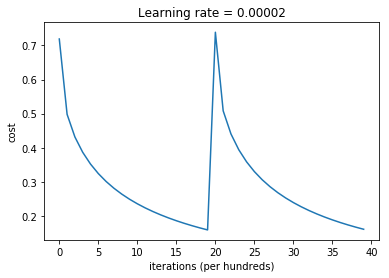

In [15]:
costs = np.squeeze(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = 0.00002")
plt.show()

读者可以看到图中成本在刚开始收敛较快，随着迭代次数变多，收敛速度变慢，最终收敛到一个较小值。

y = 1, you predicted that it is a "cat" picture.


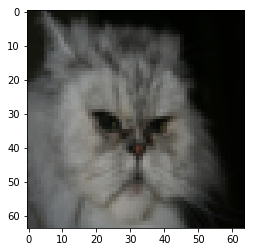

In [16]:
# Example of a picture that was wrongly classified.
index = 12
plt.imshow((np.array(test_data['image'][index])).reshape((64, 64, 3)))
print ("y = " + str(test_data_y[index]) + ", you predicted that it is a \"" + classes[test_data_y[index]].decode("utf-8") +  "\" picture.")